<a href="https://colab.research.google.com/github/ounospanas/AIDL_A_02/blob/main/MoRSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset of "MoRSE: Deep Learning-based Arm Gesture Recognition for Search and Rescue Operations"
https://arxiv.org/pdf/2210.08307.pdf

In [1]:
!gdown 1lt2VimIv8AKfvVo9kcWoAj9T3SRLhrPQ

Downloading...
From: https://drive.google.com/uc?id=1lt2VimIv8AKfvVo9kcWoAj9T3SRLhrPQ
To: /content/morse_dataset.zip
100% 54.4M/54.4M [00:00<00:00, 59.4MB/s]


In [2]:
!unzip morse_dataset.zip

Archive:  morse_dataset.zip
   creating: morse_data/
  inflating: morse_data/acc_random_s_0.csv  
  inflating: morse_data/acc_random_s_1.csv  
  inflating: morse_data/acc_random_s_2.csv  
  inflating: morse_data/acc_random_s_3.csv  
  inflating: morse_data/acc_random_s_4.csv  
  inflating: morse_data/acc_random_s_5.csv  
  inflating: morse_data/acc_random_s_6.csv  
  inflating: morse_data/acc_random_s_7.csv  
  inflating: morse_data/acc_s_0.csv  
  inflating: morse_data/acc_s_1.csv  
  inflating: morse_data/acc_s_2.csv  
  inflating: morse_data/acc_s_3.csv  
  inflating: morse_data/acc_s_4.csv  
  inflating: morse_data/acc_s_5.csv  
  inflating: morse_data/acc_s_6.csv  
  inflating: morse_data/gyro_random_s_0.csv  
  inflating: morse_data/gyro_random_s_1.csv  
  inflating: morse_data/gyro_random_s_2.csv  
  inflating: morse_data/gyro_random_s_3.csv  
  inflating: morse_data/gyro_random_s_4.csv  
  inflating: morse_data/gyro_random_s_5.csv  
  inflating: morse_data/gyro_random_s_6.csv  

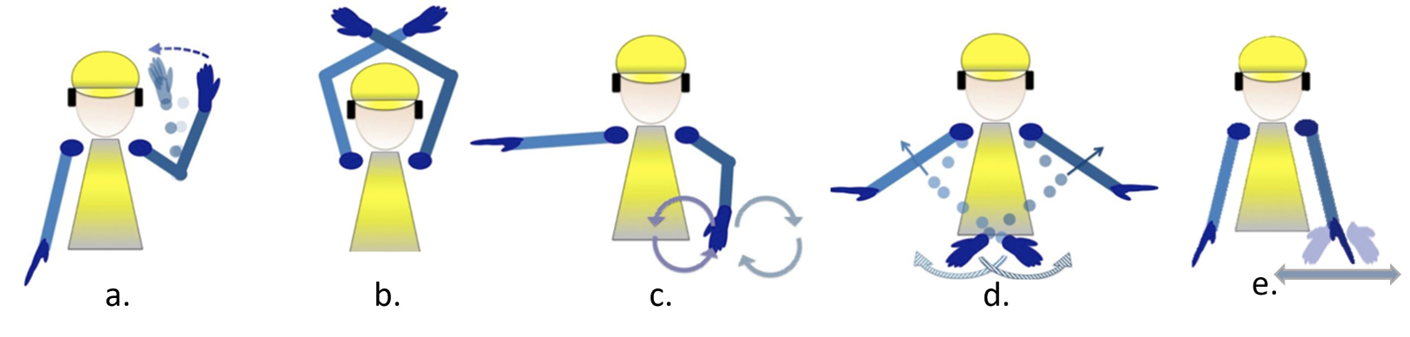

# Import Dependencies

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalMaxPool2D, Dense, Dropout, Flatten, LSTM, Activation, concatenate, BatchNormalization, Permute, Reshape, Layer, AveragePooling2D, GlobalAvgPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

In [4]:
rows, cols, channels = 6, 250, 1
n_subjects = 7
nb_classes = 6
batch_size = 128
random_gestures = 100

# Load dataset and preprocess it

In [5]:
datas = []
ys = []

for i in range(0,n_subjects):
    print(i)

    df = pd.read_csv('morse_data/acc_s_'+str(i)+'.csv', names=['time_1','time_2','acc_x','acc_y','acc_z','y'])
    sub1 = df[['acc_x','acc_y','acc_z']].to_numpy()
    size = int(len(sub1)/cols)
    acc = np.zeros((size+random_gestures,3,cols,1))
    for j in range(size):
        acc[j,:,:,0] = sub1[j*cols:cols*(j+1),:].T



    df = pd.read_csv('morse_data/gyro_s_'+str(i)+'.csv', names=['time_1','time_2','gyr_x','gyr_y','gyr_z','y'])
    sub1 = df[['gyr_x','gyr_y','gyr_z']].to_numpy()
    gyr = np.zeros((size+random_gestures,3,cols,1))
    for j in range(size):
        gyr[j,:,:,0] = sub1[j*cols:cols*(j+1),:].T

    y = df['y'][::cols].to_numpy()

    data = np.zeros((size+random_gestures,6,cols,1))
    data[:,:3,:,:] = acc
    data[:,3:,:,:] = gyr


    df = pd.read_csv('morse_data/acc_random_s_'+str(i)+'.csv', names=['time_1','time_2','acc_x','acc_y','acc_z','y'])
    sub1 = df[['acc_x','acc_y','acc_z']].to_numpy()

    acc_r = np.zeros((random_gestures,3,cols,1))
    for j in range(random_gestures):
        acc_r[j,:,:,0] = sub1[j*cols:cols*(j+1),:].T

    df_gyr = pd.read_csv('morse_data/gyro_random_s_'+str(i)+'.csv', names=['time_1','time_2','acc_x','acc_y','acc_z','y'])
    sub1 = df_gyr[['acc_x','acc_y','acc_z']].to_numpy()

    gyr_r = np.zeros((random_gestures,3,cols,1))
    for j in range(random_gestures):
        gyr_r[j,:,:,0] = sub1[j*cols:cols*(j+1),:].T


    data[-random_gestures:,:3,:,:] = acc_r
    data[-random_gestures:,3:,:,:] = gyr_r

    y_all = np.zeros(size+random_gestures)
    y_all[:-random_gestures] = y

    print(np.unique(y_all))
    datas.append(data)
    ys.append(y_all)
    print(y_all.shape, data.shape)

0
[0. 1. 2. 3. 4. 5.]
(601,) (601, 6, 250, 1)
1
[0. 1. 2. 3. 4. 5.]
(600,) (600, 6, 250, 1)
2
[0. 1. 2. 3. 4. 5.]
(570,) (570, 6, 250, 1)
3
[0. 1. 2. 3. 4. 5.]
(600,) (600, 6, 250, 1)
4
[0. 1. 2. 3. 4. 5.]
(623,) (623, 6, 250, 1)
5
[0. 1. 2. 3. 4. 5.]
(609,) (609, 6, 250, 1)
6
[0. 1. 2. 3. 4. 5.]
(600,) (600, 6, 250, 1)


In [6]:
def losoSplit(data, data_y, val = 3, test = 4):

    X_val = np.copy(data[val])[:,:,:,:]
    y_val = np.copy(data_y[val])

    X_test = np.copy(data[test])[:,:,:,:]
    y_test = np.copy(data_y[test])

    X_train = np.concatenate([np.copy(data[i]) for i in range(0,len(data)) if i not in [test, val]])[:,:,:,:]
    y_train = np.concatenate([np.copy(data_y[i]) for i in range(0,len(data)) if i not in [test,val]])

    return X_val, y_val, X_test, y_test, X_train, y_train

In [7]:
def z_score(X_train):
    X_means = np.zeros(6)
    X_stds = np.zeros(6)

    for i in range(6):
        X_means[i] = np.mean(X_train[:,i,:,:])
        X_stds[i] = np.std(X_train[:,i,:,:])

        X_train[:,i,:,:] = (X_train[:,i,:,:] - X_means[i])/X_stds[i]
        X_val[:,i,:,:] = (X_val[:,i,:,:] - X_means[i])/X_stds[i]
        X_test[:,i,:,:] = (X_test[:,i,:,:] - X_means[i])/X_stds[i]

    return X_val,X_test,X_train,X_means,X_stds

# Deep Learning Models

In [8]:
def lstmModel(c = 32,f = 5):
    inputs = Input(shape=(rows, cols, channels,))

    x = Conv2D(c, (1, f), padding='same', name='1st_Convolutional', )(inputs)
    x = Activation('relu', name='relu_1')(x)

    x = Conv2D(c, (1, f), padding='same', name='2nd_Convolutional')(x)
    x = Activation('relu', name='relu_2')(x)

    x = Conv2D(c, (1, f), padding='same', name='3rd_Convolutional')(x)
    x = Activation('relu', name='relu_3')(x)

    x = Conv2D(c, (1, f), padding='same', name='4th_Convolutional')(x)
    x = Activation('relu', name='relu_4')(x)

    a = Permute((2,1,3))(x)
    a = Reshape((250,6*c))(a)

    a = Dropout(0.25)(a)
    a = LSTM(16)(a)
    a = Dropout(0.25)(a)

    a = Dense(nb_classes)(a)
    predictions = Activation('softmax')(a)

    model = Model(inputs=[inputs], outputs=predictions)
    return model

In [10]:
def myModel(c = [12,24,32],f = [11,11,11]):
    inputs = Input(shape=(rows, cols, channels,))

    x = Conv2D(c[0], (1, f[0]), padding='same', name='1st_Convolutional', )(inputs)
    x = Activation('relu', name='relu_1')(x)
    x = MaxPooling2D(pool_size=(1, 4))(x)
    x = Dropout(0.50)(x)

    x = Conv2D(c[1], (1, f[1]), padding='same', name='2nd_Convolutional')(x)
    x = Activation('relu', name='relu_2')(x)
    x = MaxPooling2D(pool_size=(1, 2))(x)
    x = Dropout(0.50)(x)

    x = Conv2D(c[2], (6, f[2]), padding='same', name='3rd_Convolutional')(x)
    x = Activation('relu', name='relu')(x)
    x = GlobalMaxPool2D(name='embeddings')(x)

    a = Dropout(0.50)(x)
    a = Dense(nb_classes)(a)
    predictions = Activation('softmax')(a)

    model = Model(inputs=[inputs], outputs=predictions)
    return model

In [11]:
def CNN_lp(c = [12,24,32],f = [11,11,11]):
    inputs = Input(shape=(rows, cols, channels,))

    x = Conv2D(c[0], (1, f[0]), padding='same', dilation_rate=1, name='1st_Convolutional', )(inputs)
    x = Activation('relu', name='relu_1')(x)
    x = Conv2D(c[0], (1, 4), padding='same', strides=(1,4), name='conv_pooling_1', activation='relu')(x)
    x = Dropout(0.50)(x)

    x = Conv2D(c[1], (1, f[1]), padding='same', dilation_rate=1, name='2nd_Convolutional')(x)
    x = Activation('relu', name='relu_2')(x)
    x = Conv2D(c[1], (1, 2), padding='same', strides=(1,2), name='conv_pooling_2',activation='relu')(x)
    x = Dropout(0.50)(x)

    x = Conv2D(c[2], (rows, f[2]), padding='same', dilation_rate=1, name='3rd_Convolutional')(x)
    x = Activation('relu', name='relu_3')(x)
    x = GlobalMaxPool2D(name='embeddings')(x)

    print(x.shape)

    a = Dropout(0.50)(x)
    a = Dense(nb_classes)(a)
    predictions = Activation('softmax')(a)

    model = Model(inputs=[inputs], outputs=predictions)
    return model

# Model training
### Trained using a cross-validation LOSO set up for 5 times to ensure reproducability

In [14]:
reproducibility = 1 # in the paper this was set to 5

accs = np.zeros((7,reproducibility))
accs_val = np.zeros((7,reproducibility))
conf_mats = np.zeros((nb_classes, nb_classes, n_subjects, reproducibility))

pairs = [(0,1),(1,2),(2,3),(3,4),(4,5),(5,6),(6,0)]

for p in pairs:
    print(p[0], p[1])
    X_val, y_val, X_test, y_test, X_train, y_train = losoSplit(datas, ys, p[0], p[1])
    X_val,X_test,X_train,X_means,X_stds = z_score(X_train)
    Y_train = utils.to_categorical(y_train, nb_classes).astype('float32')
    Y_val = utils.to_categorical(y_val, nb_classes).astype('float32')
    Y_test = utils.to_categorical(y_test, nb_classes).astype('float32')

    for i in range(reproducibility):
        model = CNN_lp()
        adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        model.compile(loss='categorical_crossentropy',
                      optimizer=adam,
                      metrics=['accuracy'])

        patience = 20 # in the paper this is set to 200

        earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')

        checkpoint = ModelCheckpoint('models/morse_'+str(p[0])+str(p[1])+'_'+str(i)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        hist = model.fit([X_train], Y_train,
                      batch_size=batch_size,
                      epochs=50, # in the paper this was set 2000
                      validation_data=([X_val], Y_val),
                      shuffle=True,
                      callbacks=[checkpoint,earlyStopping],
                      verbose=2)

        # load best saved model
        model.load_weights('models/morse_'+str(p[0])+str(p[1])+'_'+str(i)+'.h5')
        preds = np.argmax(model.predict(X_test),1)
        accs[p[1],i] = np.mean(preds==y_test)
        accs_val[p[0],i] = np.mean(np.argmax(model.predict(X_val),1)== y_val)
        conf_mat = confusion_matrix(preds,y_test)
        conf_mats[:,:,p[0],i] = conf_mat

0 1
(None, 32)
Epoch 1/50

Epoch 1: val_loss improved from inf to 1.45764, saving model to models/morse_01_0.h5
24/24 - 2s - loss: 1.6296 - accuracy: 0.2305 - val_loss: 1.4576 - val_accuracy: 0.7221 - 2s/epoch - 104ms/step
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.45764 to 0.90716, saving model to models/morse_01_0.h5
24/24 - 0s - loss: 1.2760 - accuracy: 0.4620 - val_loss: 0.9072 - val_accuracy: 0.8303 - 289ms/epoch - 12ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.90716 to 0.54603, saving model to models/morse_01_0.h5
24/24 - 0s - loss: 0.9000 - accuracy: 0.6382 - val_loss: 0.5460 - val_accuracy: 0.8369 - 271ms/epoch - 11ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.54603 to 0.35755, saving model to models/morse_01_0.h5
24/24 - 0s - loss: 0.6513 - accuracy: 0.7492 - val_loss: 0.3576 - val_accuracy: 0.9917 - 278ms/epoch - 12ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.35755 to 0.25642, saving model to models/morse_01_0.h5
24/24 - 0s - loss: 0.5041 - accuracy: 0.8208 - val_loss: 0.2564 - val_accuracy: 0.9800 - 271ms/epoch - 11ms/step
Epoch 6/50

Epoch 6: val_loss improved from 0.25642 to 0.19097, saving model to models/morse_01_0.h5
24/24 - 0s - loss: 0.4066 - accuracy: 0.8698 - val_los

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.69515 to 0.94098, saving model to models/morse_12_0.h5
24/24 - 0s - loss: 1.2566 - accuracy: 0.5048 - val_loss: 0.9410 - val_accuracy: 0.7150 - 361ms/epoch - 15ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.94098 to 0.62378, saving model to models/morse_12_0.h5
24/24 - 0s - loss: 0.6027 - accuracy: 0.7864 - val_loss: 0.6238 - val_accuracy: 0.8000 - 282ms/epoch - 12ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.62378 to 0.55376, saving model to models/morse_12_0.h5
24/24 - 0s - loss: 0.3385 - accuracy: 0.8859 - val_loss: 0.5538 - val_accuracy: 0.8083 - 271ms/epoch - 11ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.55376 to 0.55128, saving model to models/morse_12_0.h5
24/24 - 0s - loss: 0.2355 - accuracy: 0.9285 - val_loss: 0.5513 - val_accuracy: 0.8083 - 273ms/epoch - 11ms/step
Epoch 6/50

Epoch 6: val_loss improved from 0.55128 to 0.54880, saving model to models/morse_12_0.h5
24/24 - 0s - loss: 0.2218 - accuracy: 0.9321 - val_los

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.64885 to 1.10108, saving model to models/morse_23_0.h5
24/24 - 0s - loss: 1.4633 - accuracy: 0.3858 - val_loss: 1.1011 - val_accuracy: 0.6649 - 283ms/epoch - 12ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.10108 to 0.56013, saving model to models/morse_23_0.h5
24/24 - 0s - loss: 0.7489 - accuracy: 0.7260 - val_loss: 0.5601 - val_accuracy: 0.9000 - 275ms/epoch - 11ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.56013 to 0.44112, saving model to models/morse_23_0.h5
24/24 - 0s - loss: 0.4507 - accuracy: 0.8473 - val_loss: 0.4411 - val_accuracy: 0.9316 - 287ms/epoch - 12ms/step
Epoch 5/50

Epoch 5: val_loss did not improve from 0.44112
24/24 - 0s - loss: 0.3522 - accuracy: 0.8978 - val_loss: 0.4592 - val_accuracy: 0.9140 - 238ms/epoch - 10ms/step
Epoch 6/50

Epoch 6: val_loss improved from 0.44112 to 0.33920, saving model to models/morse_23_0.h5
24/24 - 0s - loss: 0.3000 - accuracy: 0.9116 - val_loss: 0.3392 - val_accuracy: 0.9474 - 276ms/e

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.27580 to 0.63114, saving model to models/morse_34_0.h5
24/24 - 0s - loss: 0.9876 - accuracy: 0.6003 - val_loss: 0.6311 - val_accuracy: 0.8917 - 277ms/epoch - 12ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.63114 to 0.35647, saving model to models/morse_34_0.h5
24/24 - 0s - loss: 0.5543 - accuracy: 0.7980 - val_loss: 0.3565 - val_accuracy: 0.9483 - 281ms/epoch - 12ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.35647 to 0.28824, saving model to models/morse_34_0.h5
24/24 - 0s - loss: 0.3723 - accuracy: 0.8866 - val_loss: 0.2882 - val_accuracy: 0.9267 - 277ms/epoch - 12ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.28824 to 0.20043, saving model to models/morse_34_0.h5
24/24 - 0s - loss: 0.3003 - accuracy: 0.9044 - val_loss: 0.2004 - val_accuracy: 0.9650 - 316ms/epoch - 13ms/step
Epoch 6/50

Epoch 6: val_loss did not improve from 0.20043
24/24 - 0s - loss: 0.2658 - accuracy: 0.9218 - val_loss: 0.2530 - val_accuracy: 0.9400 - 237ms/e

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.74757 to 1.30492, saving model to models/morse_45_0.h5
24/24 - 0s - loss: 1.5265 - accuracy: 0.3733 - val_loss: 1.3049 - val_accuracy: 0.6533 - 276ms/epoch - 11ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.30492 to 0.63525, saving model to models/morse_45_0.h5
24/24 - 0s - loss: 0.9301 - accuracy: 0.6368 - val_loss: 0.6352 - val_accuracy: 0.8973 - 275ms/epoch - 11ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.63525 to 0.37230, saving model to models/morse_45_0.h5
24/24 - 0s - loss: 0.4928 - accuracy: 0.8193 - val_loss: 0.3723 - val_accuracy: 0.9213 - 276ms/epoch - 12ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.37230 to 0.32084, saving model to models/morse_45_0.h5
24/24 - 0s - loss: 0.3657 - accuracy: 0.8906 - val_loss: 0.3208 - val_accuracy: 0.9358 - 278ms/epoch - 12ms/step
Epoch 6/50

Epoch 6: val_loss did not improve from 0.32084
24/24 - 0s - loss: 0.2890 - accuracy: 0.9101 - val_loss: 0.3257 - val_accuracy: 0.9294 - 236ms/e

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.49547 to 0.68037, saving model to models/morse_56_0.h5
24/24 - 0s - loss: 1.2280 - accuracy: 0.5261 - val_loss: 0.6804 - val_accuracy: 0.8966 - 270ms/epoch - 11ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.68037 to 0.42732, saving model to models/morse_56_0.h5
24/24 - 0s - loss: 0.6806 - accuracy: 0.7435 - val_loss: 0.4273 - val_accuracy: 0.9475 - 270ms/epoch - 11ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.42732 to 0.25653, saving model to models/morse_56_0.h5
24/24 - 0s - loss: 0.4301 - accuracy: 0.8587 - val_loss: 0.2565 - val_accuracy: 0.9409 - 281ms/epoch - 12ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.25653 to 0.21094, saving model to models/morse_56_0.h5
24/24 - 0s - loss: 0.3457 - accuracy: 0.8898 - val_loss: 0.2109 - val_accuracy: 0.9606 - 272ms/epoch - 11ms/step
Epoch 6/50

Epoch 6: val_loss improved from 0.21094 to 0.14548, saving model to models/morse_56_0.h5
24/24 - 0s - loss: 0.2767 - accuracy: 0.9222 - val_los

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.45924 to 1.12919, saving model to models/morse_60_0.h5
24/24 - 0s - loss: 1.3910 - accuracy: 0.4257 - val_loss: 1.1292 - val_accuracy: 0.7350 - 284ms/epoch - 12ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.12919 to 0.61544, saving model to models/morse_60_0.h5
24/24 - 0s - loss: 0.9279 - accuracy: 0.6422 - val_loss: 0.6154 - val_accuracy: 0.8683 - 282ms/epoch - 12ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.61544 to 0.52734, saving model to models/morse_60_0.h5
24/24 - 0s - loss: 0.5633 - accuracy: 0.8055 - val_loss: 0.5273 - val_accuracy: 0.8267 - 272ms/epoch - 11ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.52734 to 0.43506, saving model to models/morse_60_0.h5
24/24 - 0s - loss: 0.4011 - accuracy: 0.8748 - val_loss: 0.4351 - val_accuracy: 0.8517 - 272ms/epoch - 11ms/step
Epoch 6/50

Epoch 6: val_loss improved from 0.43506 to 0.33884, saving model to models/morse_60_0.h5
24/24 - 0s - loss: 0.3252 - accuracy: 0.9084 - val_los

In [15]:
print("Average test accuracy:", np.mean(accs))
print("Average validation accuracy", np.mean(accs_val))

Average test accuracy: 0.9488319424636081
Average validation accuracy 0.9603144787571329


Text(0.5, 1.0, 'Confusion Matrix')

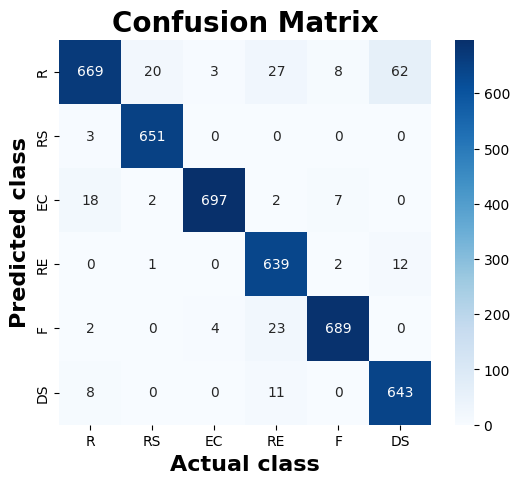

In [16]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
classes = ['R', 'RS', 'EC', 'RE','F', 'DS']

sum_cfs = np.sum(np.sum(conf_mats,3),2)

df_cm = pd.DataFrame(sum_cfs.astype(int), index = [i for i in classes],columns = [i for i in classes])
plt.figure(figsize = (6,5))


ax = sn.heatmap(df_cm, annot=True,fmt='g',cmap='Blues')

ax.set_xlabel(xlabel='Actual class', fontsize=16, fontdict=dict(weight='bold'))
ax.set_ylabel(ylabel='Predicted class', fontsize=16, fontdict=dict(weight='bold'))

ax.set_title('Confusion Matrix',fontsize=20, fontdict=dict(weight='bold'))

# Convert to tf-lite

In [41]:
# save the model to .pb
model = tf.keras.models.load_model('models/morse_'+str(2)+str(3)+'_'+str(0)+'.h5')
model.save('models/morse_'+str(2)+str(3)+'_'+str(0))

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('models/morse_'+str(2)+str(3)+'_'+str(0)) # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

intepreter = tf.lite.Interpreter(model_path='model.tflite')

intepreter.allocate_tensors()
input_details = intepreter.get_input_details()
output_details = intepreter.get_output_details()

In [42]:
X_val, y_val, X_test, y_test, X_train, y_train = losoSplit(datas, ys, 2, 3)
X_val,X_test,X_train,X_means,X_stds = z_score(X_train)

model = tf.keras.models.load_model('models/morse_'+str(2)+str(3)+'_'+str(0))

np.mean(np.argmax(model.predict(X_test),1)== y_test)

19/19 [==============================] - 0s 2ms/step


0.9766666666666667

In [43]:
input_data = np.expand_dims(X_test[0],axis=0).astype(np.float32)

intepreter.set_tensor(input_details[0]['index'], input_data)
intepreter.invoke()

predictions = intepreter.get_tensor(output_details[0]['index'])[0]

In [44]:
print("tf-lite model predictions:", predictions)
print("tf model predictions:",model.predict(X_test[:1])[0])

tf-lite model predictions: [5.09884899e-07 9.99992013e-01 1.81261811e-07 7.11341318e-06
 1.00918946e-07 4.13719725e-08]
1/1 [==============================] - 0s 17ms/step
tf model predictions: [5.0804107e-07 9.9999213e-01 1.8025665e-07 7.0826950e-06 1.0034621e-07
 4.1167471e-08]


In [45]:
%%time
for i in range(1000):
  intepreter.set_tensor(input_details[0]['index'], input_data)
  intepreter.invoke()
  predictions = intepreter.get_tensor(output_details[0]['index'])[0]

CPU times: user 398 ms, sys: 1.91 ms, total: 400 ms
Wall time: 399 ms


In [46]:
%%time
for i in range(1000):
  model.predict(input_data,verbose = 0)

CPU times: user 56.7 s, sys: 1.62 s, total: 58.3 s
Wall time: 1min
